### TODO:

Modify the values for direction, either giving them a sin and cos value using circular encoding, or categorical encogding or normalization (ask prof)

apply reduction on the multiple speeds and directions. are they even useful

Does wind direction even matter once the residuals of the wind speed are taken out. How to make the best use of this metric. Figure out hwo the direction values are calculated

In [80]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score, accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from statsmodels.tsa.vector_ar.var_model import VAR
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

import xgboost as xgb

from sktime.performance_metrics.forecasting import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

from tabulate import tabulate

In [81]:
DATA_PATH = 'Datasets'

df_wf1 = pd.read_excel(
    os.path.join(DATA_PATH,'Wind farm site 1 (Nominal capacity-99MW).xlsx'), 
)

pd.set_option('display.max_columns', None)
df_wf1

,Time(year-month-day h:m:s),Wind speed at height of 10 meters (m/s),Wind direction at height of 10 meters (˚),Wind speed at height of 30 meters (m/s),Wind direction at height of 30 meters (˚),Wind speed at height of 50 meters (m/s),Wind direction at height of 50 meters (˚),Wind speed - at the height of wheel hub (m/s),Wind speed - at the height of wheel hub (˚),Air temperature (°C),Atmosphere (hpa),Relative humidity (%),Power (MW)
0,2019-01-01 00:00:00,2.209,81.317,1.991,74.814,2.094,77.667,2.494,74.500,-13.484,889.867,76.320,0.254383
1,2019-01-01 00:15:00,1.828,77.460,1.698,75.048,1.757,88.733,1.882,74.367,-13.691,889.575,76.757,0.329703
2,2019-01-01 00:30:00,2.193,86.700,2.313,84.688,2.344,89.100,2.350,89.000,-13.766,889.942,76.981,0.296306
3,2019-01-01 00:45:00,2.654,78.160,2.494,74.939,2.574,87.267,2.808,82.733,-13.691,889.675,76.821,0.187590
4,2019-01-01 01:00:00,2.249,94.297,2.192,91.140,2.558,96.900,2.924,92.967,-13.447,890.025,74.571,0.081005
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70171,2020-12-31 22:45:00,5.738,234.600,6.408,235.454,6.575,242.033,6.680,238.433,-9.108,890.008,53.312,13.633642
70172,2020-12-31 23:00:00,5.748,229.333,6.231,233.423,6.372,239.800,6.448,236.833,-9.978,889.817,53.877,6.869759
70173,2020-12-31 23:15:00,4.468,235.133,4.406,253.261,4.381,263.400,4.399,261.733,-9.808,889.825,54.437,4.352931
70174,2020-12-31 23:30:00,3.730,242.580,3.280,252.492,3.204,268.600,3.446,266.733,-9.633,889.492,54.677,7.185250


In [82]:
df_wf1.columns=['time','WS_10','WD_10','WS_30','WD_30','WS_50','WD_50','WS_cen','WD_cen','Air_T','Air_P','Air_H','Power(MW)']
df_wf1

,time,WS_10,WD_10,WS_30,WD_30,WS_50,WD_50,WS_cen,WD_cen,Air_T,Air_P,Air_H,Power(MW)
0,2019-01-01 00:00:00,2.209,81.317,1.991,74.814,2.094,77.667,2.494,74.500,-13.484,889.867,76.320,0.254383
1,2019-01-01 00:15:00,1.828,77.460,1.698,75.048,1.757,88.733,1.882,74.367,-13.691,889.575,76.757,0.329703
2,2019-01-01 00:30:00,2.193,86.700,2.313,84.688,2.344,89.100,2.350,89.000,-13.766,889.942,76.981,0.296306
3,2019-01-01 00:45:00,2.654,78.160,2.494,74.939,2.574,87.267,2.808,82.733,-13.691,889.675,76.821,0.187590
4,2019-01-01 01:00:00,2.249,94.297,2.192,91.140,2.558,96.900,2.924,92.967,-13.447,890.025,74.571,0.081005
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70171,2020-12-31 22:45:00,5.738,234.600,6.408,235.454,6.575,242.033,6.680,238.433,-9.108,890.008,53.312,13.633642
70172,2020-12-31 23:00:00,5.748,229.333,6.231,233.423,6.372,239.800,6.448,236.833,-9.978,889.817,53.877,6.869759
70173,2020-12-31 23:15:00,4.468,235.133,4.406,253.261,4.381,263.400,4.399,261.733,-9.808,889.825,54.437,4.352931
70174,2020-12-31 23:30:00,3.730,242.580,3.280,252.492,3.204,268.600,3.446,266.733,-9.633,889.492,54.677,7.185250


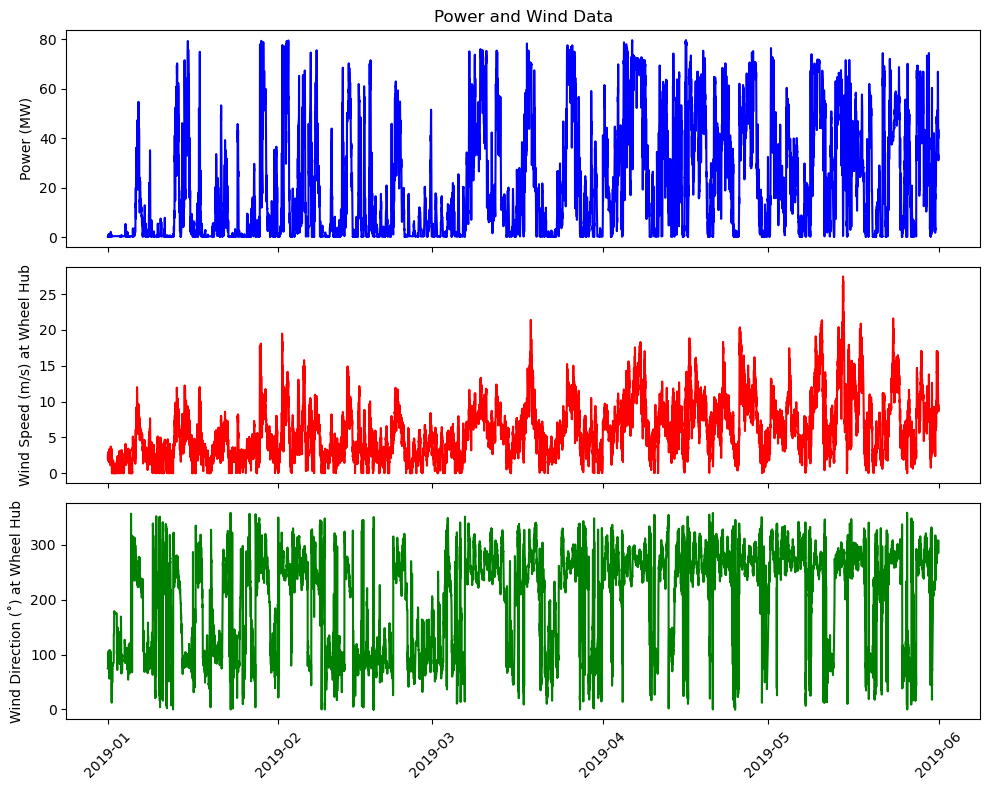

In [83]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you've already read the data and renamed the columns as you described

# Convert 'time' column to datetime type
df_wf1['time'] = pd.to_datetime(df_wf1['time'])

# Set 'time' column as the index
df_wf1.set_index('time', inplace=True)

# Filter the DataFrame for the desired date range
start_date = '2019-01-01'
end_date = '2019-05-31'
df_wf1_filtered = df_wf1.loc[start_date:end_date]

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

# Plot Power
axs[0].plot(df_wf1_filtered.index, df_wf1_filtered['Power(MW)'], color='blue')
axs[0].set_ylabel('Power (MW)')
axs[0].set_title('Power and Wind Data')

# Plot WS_cen
axs[1].plot(df_wf1_filtered.index, df_wf1_filtered['WS_cen'], color='red')
axs[1].set_ylabel('Wind Speed (m/s) at Wheel Hub')

# Plot WD_cen
axs[2].plot(df_wf1_filtered.index, df_wf1_filtered['WD_cen'], color='green')
axs[2].set_ylabel('Wind Direction (˚) at Wheel Hub')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()


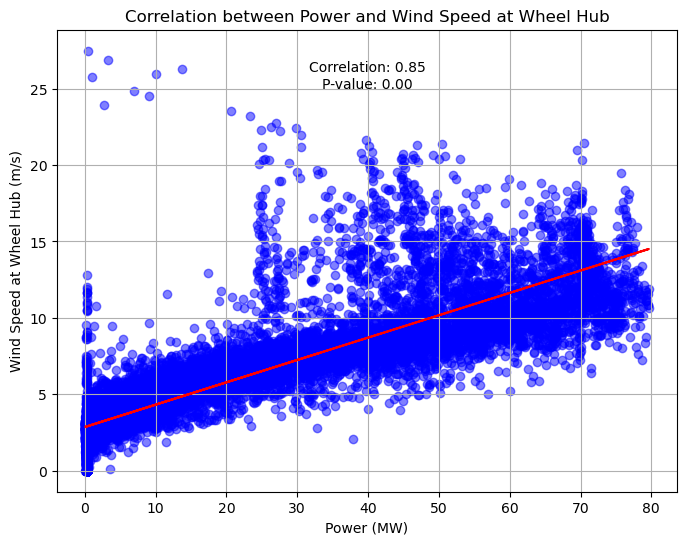

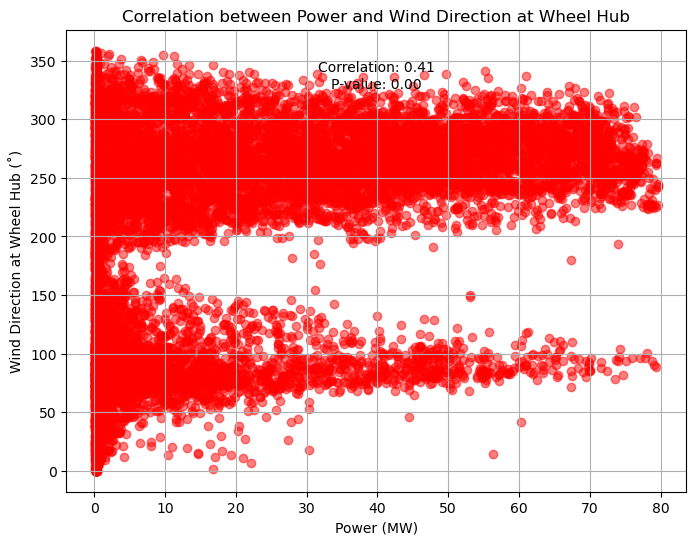

In [84]:
# Plot correlation between Power and WS_cen
plt.figure(figsize=(8, 6))
plt.scatter(df_wf1_filtered['Power(MW)'], df_wf1_filtered['WS_cen'], color='blue', alpha=0.5)
plt.title('Correlation between Power and Wind Speed at Wheel Hub')
plt.xlabel('Power (MW)')
plt.ylabel('Wind Speed at Wheel Hub (m/s)')
plt.grid(True)

# Calculate and display correlation and p-value
corr_coef, p_val = pearsonr(df_wf1_filtered['Power(MW)'], df_wf1_filtered['WS_cen'])
plt.text(0.5, 0.9, f'Correlation: {corr_coef:.2f}\nP-value: {p_val:.2f}',
         horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

# Plot line of best fit
m, b = np.polyfit(df_wf1_filtered['Power(MW)'], df_wf1_filtered['WS_cen'], 1)
plt.plot(df_wf1_filtered['Power(MW)'], m * df_wf1_filtered['Power(MW)'] + b, color='red')

plt.show()

# Plot correlation between Power and WD_cen
plt.figure(figsize=(8, 6))
plt.scatter(df_wf1_filtered['Power(MW)'], df_wf1_filtered['WD_cen'], color='red', alpha=0.5)
plt.title('Correlation between Power and Wind Direction at Wheel Hub')
plt.xlabel('Power (MW)')
plt.ylabel('Wind Direction at Wheel Hub (˚)')
plt.grid(True)

# Calculate and display correlation and p-value
corr_coef, p_val = pearsonr(df_wf1_filtered['Power(MW)'], df_wf1_filtered['WD_cen'])
plt.text(0.5, 0.9, f'Correlation: {corr_coef:.2f}\nP-value: {p_val:.2f}',
         horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

# Plot line of best fit (not applicable for wind direction)
plt.show()

Shows correlation between power and wind speed, and correlation between power and direction when the hit hits the hub at 90 or 270 degrees, being max and min when direction is 0, 180 or 360 degrees

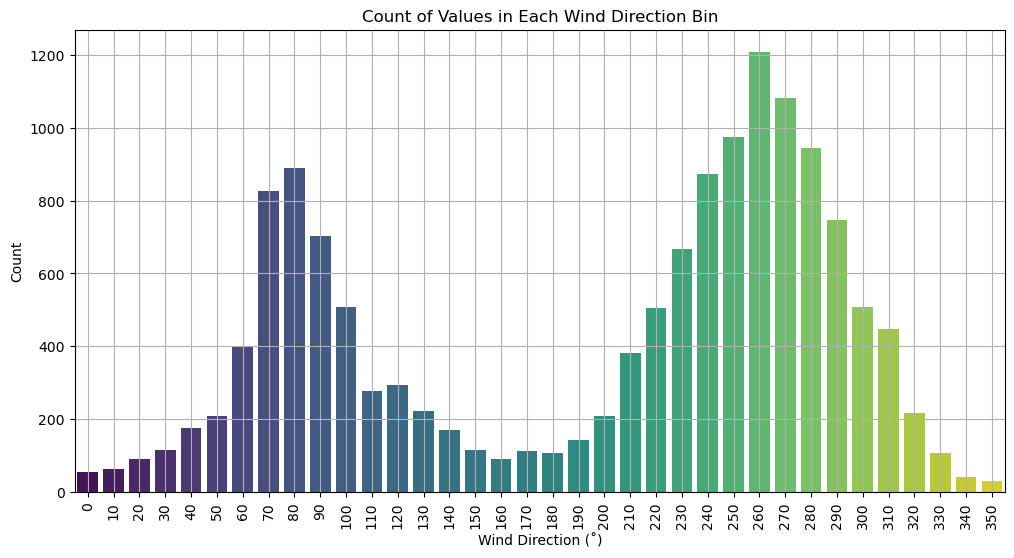

In [85]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_wf1_filtered contains the DataFrame with 'Power(MW)' and 'WD_cen' columns

# Filter rows where power is not zero
df_wf1_filtered_nonzero_power = df_wf1_filtered[df_wf1_filtered['Power(MW)'] != 0]

# Bin wind directions into 10-degree intervals
bins = np.arange(0, 370, 10)
labels = range(0, 360, 10)  # Labels for each bin

# Assign wind directions to bins
df_wf1_filtered_nonzero_power['WD_cen_bins'] = pd.cut(df_wf1_filtered_nonzero_power['WD_cen'], bins=bins, labels=labels, right=False)

# Plot countplot
plt.figure(figsize=(12, 6))
sns.countplot(x='WD_cen_bins', data=df_wf1_filtered_nonzero_power, palette='viridis')
plt.title('Count of Values in Each Wind Direction Bin')
plt.xlabel('Wind Direction (˚)')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()


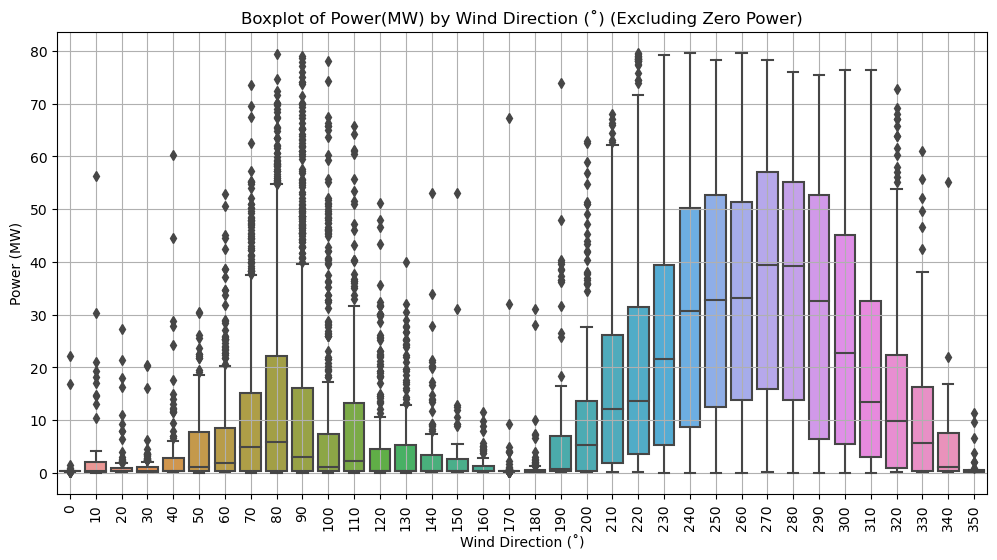

In [86]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_wf1_filtered contains the DataFrame with 'Power(MW)' and 'WD_cen' columns

# Filter rows where power is not zero
df_wf1_filtered_nonzero_power = df_wf1_filtered[df_wf1_filtered['Power(MW)'] != 0]

# Bin wind directions into 10-degree intervals
bins = np.arange(0, 370, 10)
labels = range(0, 360, 10)  # Labels for each bin

# Assign wind directions to bins
df_wf1_filtered_nonzero_power['WD_cen_bins'] = pd.cut(df_wf1_filtered_nonzero_power['WD_cen'], bins=bins, labels=labels, right=False)

# Plot boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='WD_cen_bins', y='Power(MW)', data=df_wf1_filtered_nonzero_power)
plt.title('Boxplot of Power(MW) by Wind Direction (˚) (Excluding Zero Power)')
plt.xlabel('Wind Direction (˚)')
plt.ylabel('Power (MW)')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()


In [87]:
from scipy.stats import pearsonr
import numpy as np

# Assuming df_wf1_filtered contains the DataFrame with 'Power(MW)', 'WS_cen', and 'WD_cen' columns

# Calculate residuals of power after regressing on wind speed
power_residuals = np.polyfit(df_wf1_filtered['WS_cen'], df_wf1_filtered['Power(MW)'], 1)
power_residuals = df_wf1_filtered['Power(MW)'] - (power_residuals[0] * df_wf1_filtered['WS_cen'] + power_residuals[1])

# Calculate residuals of wind speed after regressing on power
wind_speed_residuals = np.polyfit(df_wf1_filtered['Power(MW)'], df_wf1_filtered['WS_cen'], 1)
wind_speed_residuals = df_wf1_filtered['WS_cen'] - (wind_speed_residuals[0] * df_wf1_filtered['Power(MW)'] + wind_speed_residuals[1])

# Calculate correlation between power residuals and wind direction
partial_corr, p_value = pearsonr(power_residuals, df_wf1_filtered['WD_cen'])

print("Partial Correlation between Power and Wind Direction (after controlling for Wind Speed):", partial_corr)
print("P-value:", p_value)


Partial Correlation between Power and Wind Direction (after controlling for Wind Speed): 0.01073990794368871
P-value: 0.19600982787103302


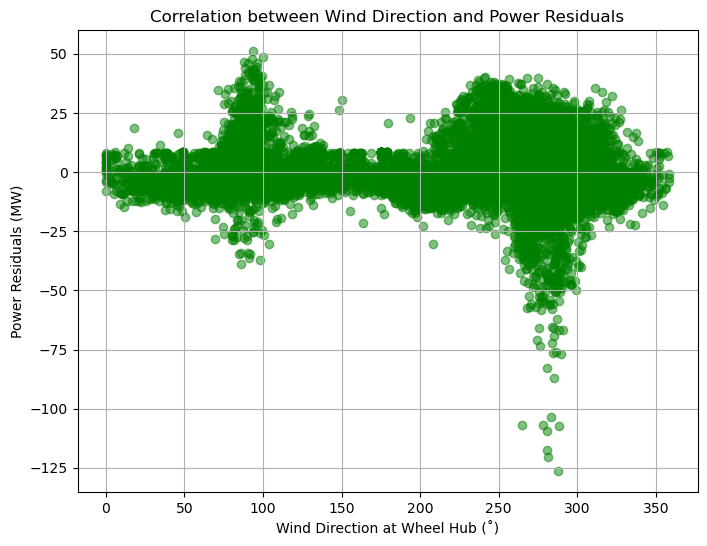

In [88]:
# Plot correlation between wind direction and power residuals
plt.figure(figsize=(8, 6))
plt.scatter(df_wf1_filtered['WD_cen'], power_residuals, color='green', alpha=0.5)
plt.title('Correlation between Wind Direction and Power Residuals')
plt.xlabel('Wind Direction at Wheel Hub (˚)')
plt.ylabel('Power Residuals (MW)')
plt.grid(True)
plt.show()


In [89]:
# Filter the DataFrame for the specified wind direction ranges
wd_0_45 = df_wf1_filtered[(df_wf1_filtered['WD_cen'] >= 0) & (df_wf1_filtered['WD_cen'] < 45)]
wd_49_135 = df_wf1_filtered[(df_wf1_filtered['WD_cen'] >= 49) & (df_wf1_filtered['WD_cen'] < 135)]
wd_135_225 = df_wf1_filtered[(df_wf1_filtered['WD_cen'] >= 135) & (df_wf1_filtered['WD_cen'] < 225)]
wd_225_315 = df_wf1_filtered[(df_wf1_filtered['WD_cen'] >= 225) & (df_wf1_filtered['WD_cen'] < 315)]
wd_315_360 = df_wf1_filtered[(df_wf1_filtered['WD_cen'] >= 315) & (df_wf1_filtered['WD_cen'] <= 360)]

# Print the number of values in each wind direction range
print("Number of values with WD_cen between 0-45:", len(wd_0_45))
print("Number of values with WD_cen between 49-135:", len(wd_49_135))
print("Number of values with WD_cen between 135-225:", len(wd_135_225))
print("Number of values with WD_cen between 225-315:", len(wd_225_315))
print("Number of values with WD_cen between 315-360:", len(wd_315_360))



Number of values with WD_cen between 0-45: 394
Number of values with WD_cen between 49-135: 4247
Number of values with WD_cen between 135-225: 1678
Number of values with WD_cen between 225-315: 7510
Number of values with WD_cen between 315-360: 602


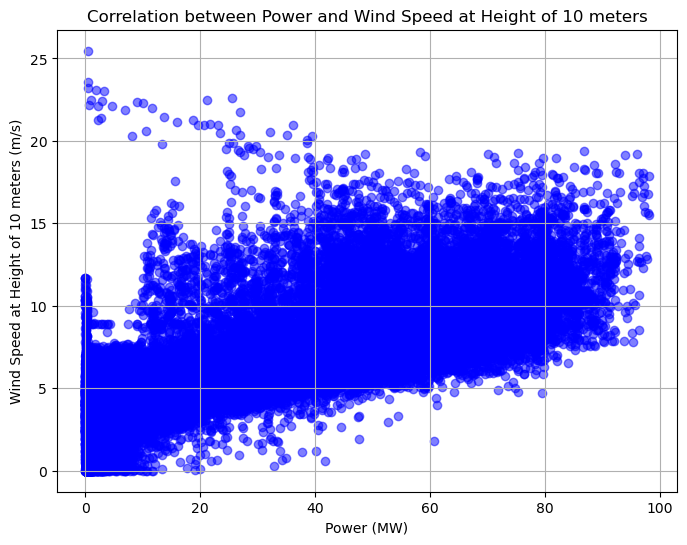

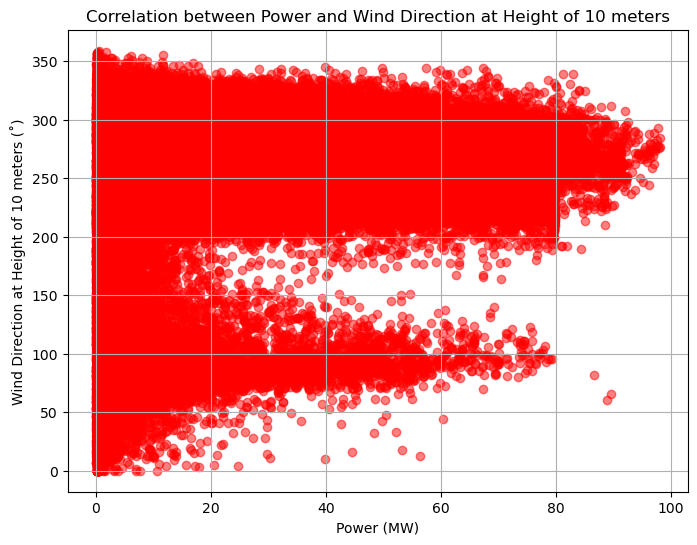

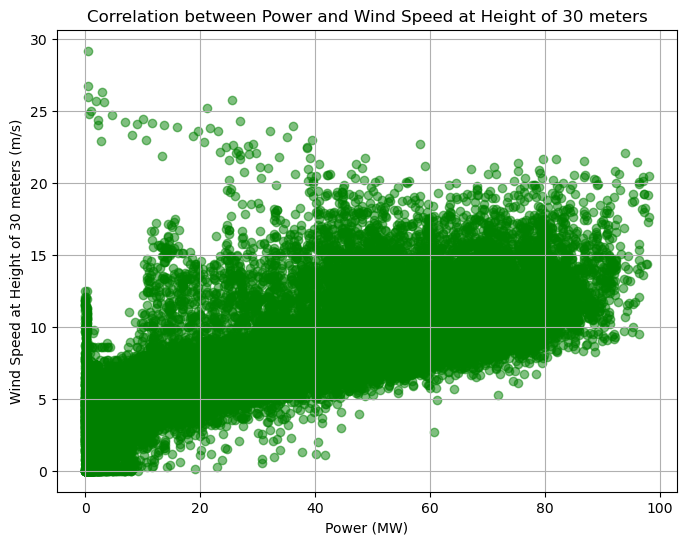

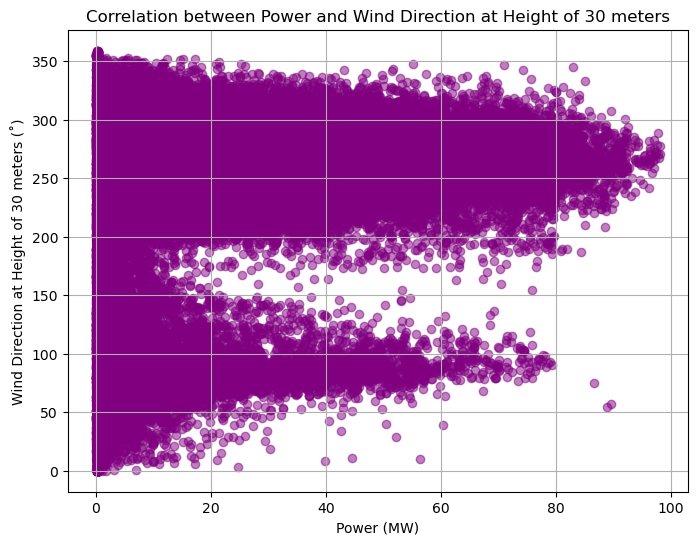

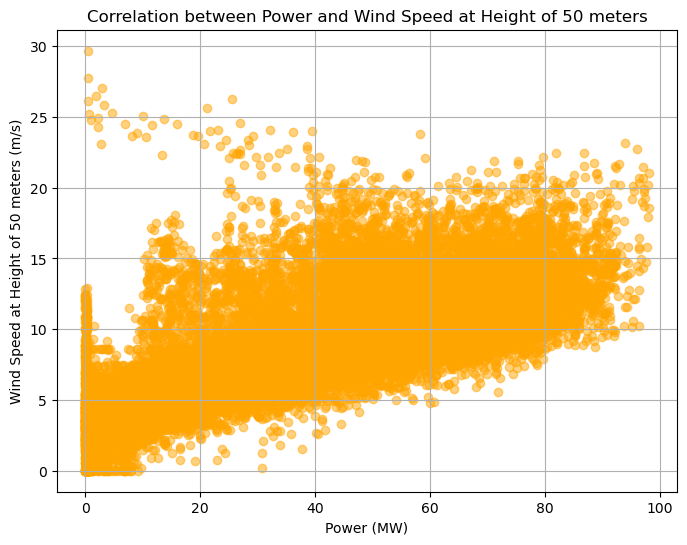

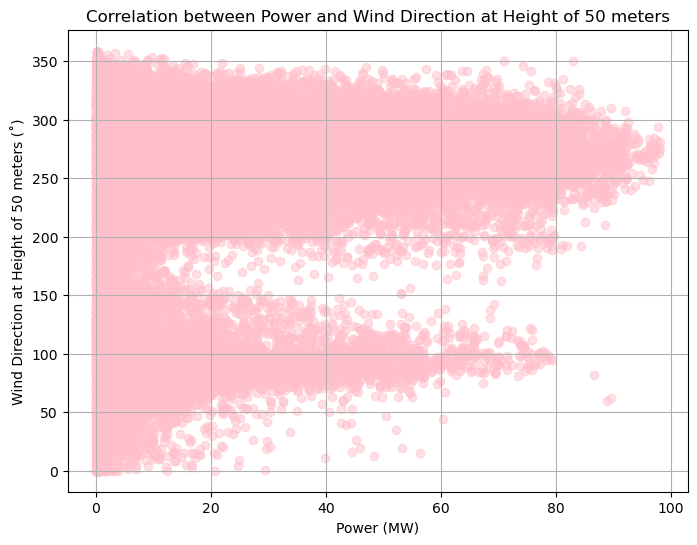

In [90]:
# Plot correlation between Power and WS_10
plt.figure(figsize=(8, 6))
plt.scatter(df_wf1['Power(MW)'], df_wf1['WS_10'], color='blue', alpha=0.5)
plt.title('Correlation between Power and Wind Speed at Height of 10 meters')
plt.xlabel('Power (MW)')
plt.ylabel('Wind Speed at Height of 10 meters (m/s)')
plt.grid(True)
plt.show()

# Plot correlation between Power and WD_10
plt.figure(figsize=(8, 6))
plt.scatter(df_wf1['Power(MW)'], df_wf1['WD_10'], color='red', alpha=0.5)
plt.title('Correlation between Power and Wind Direction at Height of 10 meters')
plt.xlabel('Power (MW)')
plt.ylabel('Wind Direction at Height of 10 meters (˚)')
plt.grid(True)
plt.show()

# Plot correlation between Power and WS_30
plt.figure(figsize=(8, 6))
plt.scatter(df_wf1['Power(MW)'], df_wf1['WS_30'], color='green', alpha=0.5)
plt.title('Correlation between Power and Wind Speed at Height of 30 meters')
plt.xlabel('Power (MW)')
plt.ylabel('Wind Speed at Height of 30 meters (m/s)')
plt.grid(True)
plt.show()

# Plot correlation between Power and WD_30
plt.figure(figsize=(8, 6))
plt.scatter(df_wf1['Power(MW)'], df_wf1['WD_30'], color='purple', alpha=0.5)
plt.title('Correlation between Power and Wind Direction at Height of 30 meters')
plt.xlabel('Power (MW)')
plt.ylabel('Wind Direction at Height of 30 meters (˚)')
plt.grid(True)
plt.show()

# Plot correlation between Power and WS_50
plt.figure(figsize=(8, 6))
plt.scatter(df_wf1['Power(MW)'], df_wf1['WS_50'], color='orange', alpha=0.5)
plt.title('Correlation between Power and Wind Speed at Height of 50 meters')
plt.xlabel('Power (MW)')
plt.ylabel('Wind Speed at Height of 50 meters (m/s)')
plt.grid(True)
plt.show()

# Plot correlation between Power and WD_50
plt.figure(figsize=(8, 6))
plt.scatter(df_wf1['Power(MW)'], df_wf1['WD_50'], color='pink', alpha=0.5)
plt.title('Correlation between Power and Wind Direction at Height of 50 meters')
plt.xlabel('Power (MW)')
plt.ylabel('Wind Direction at Height of 50 meters (˚)')
plt.grid(True)
plt.show()


c:\Users\hussa\anaconda3\envs\ml_hussa\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


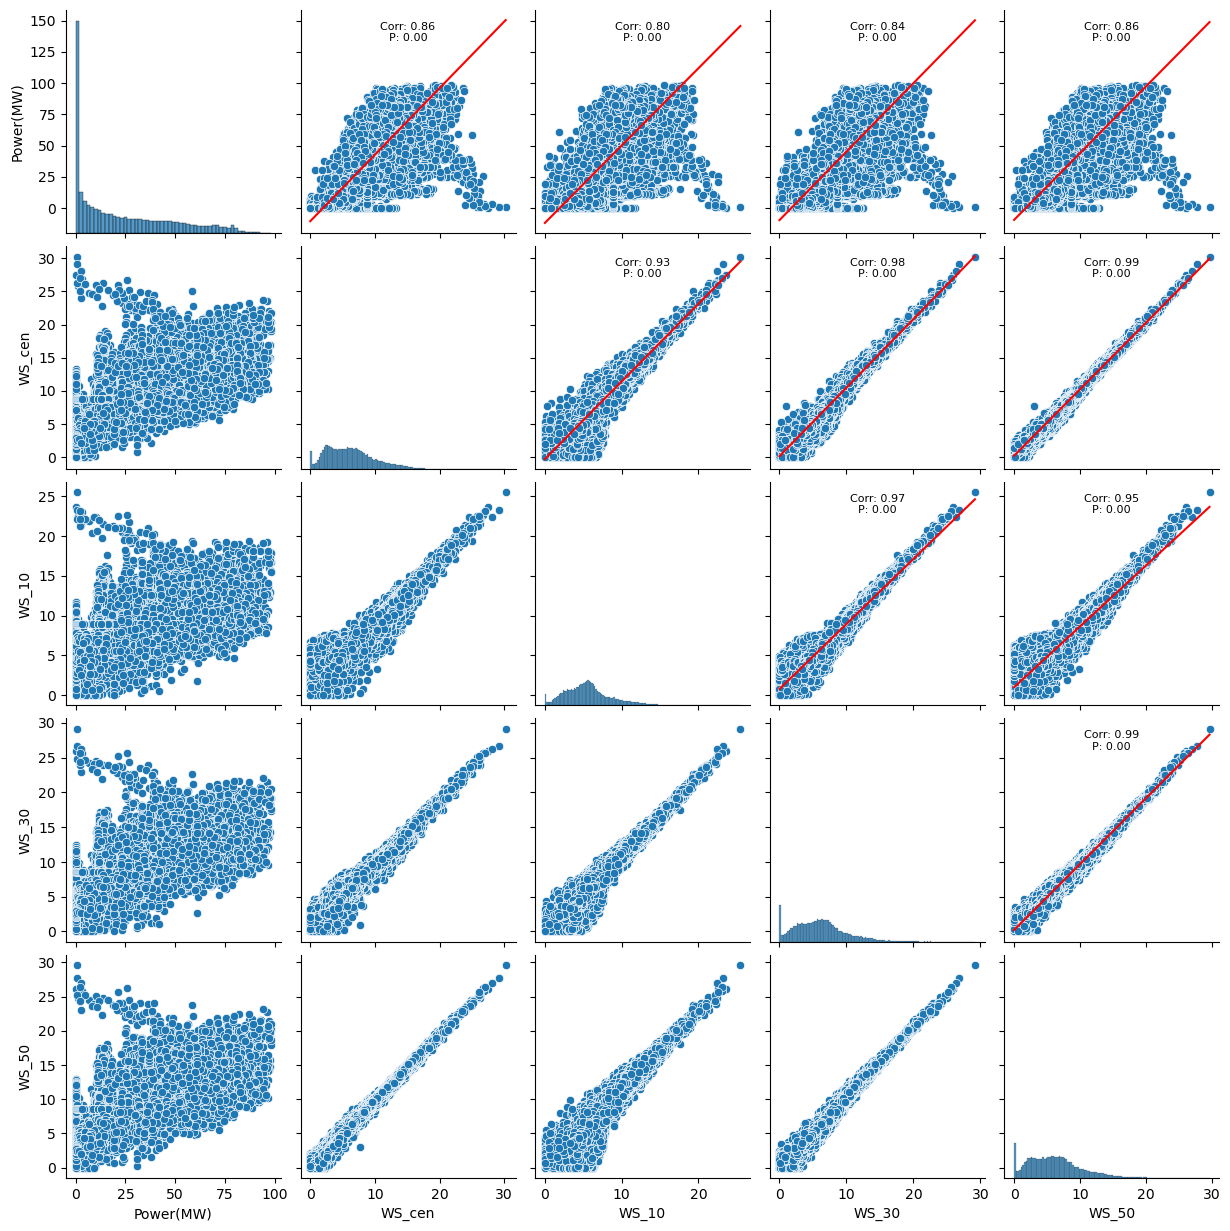

In [91]:
import seaborn as sns
import numpy as np
from scipy import stats

# Define pair plot
pair_plot = sns.pairplot(df_wf1[['Power(MW)', 'WS_cen', 'WS_10', 'WS_30', 'WS_50']])

# Calculate and display correlation and p-value
for i, j in zip(*np.triu_indices_from(pair_plot.axes, 1)):
    ax = pair_plot.axes[i, j]
    x_var, y_var = ax.collections[0].get_offsets().T
    corr_coef, p_val = stats.pearsonr(x_var, y_var)
    ax.annotate("Corr: {:.2f}\nP: {:.2f}".format(corr_coef, p_val),
                xy=(0.5, 0.9), xycoords='axes fraction',
                ha='center', va='center', fontsize=8, color='black')

    # Plot line of best fit
    ax.plot(np.unique(x_var), np.poly1d(np.polyfit(x_var, y_var, 1))(np.unique(x_var)), color='red')

plt.show()


c:\Users\hussa\anaconda3\envs\ml_hussa\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


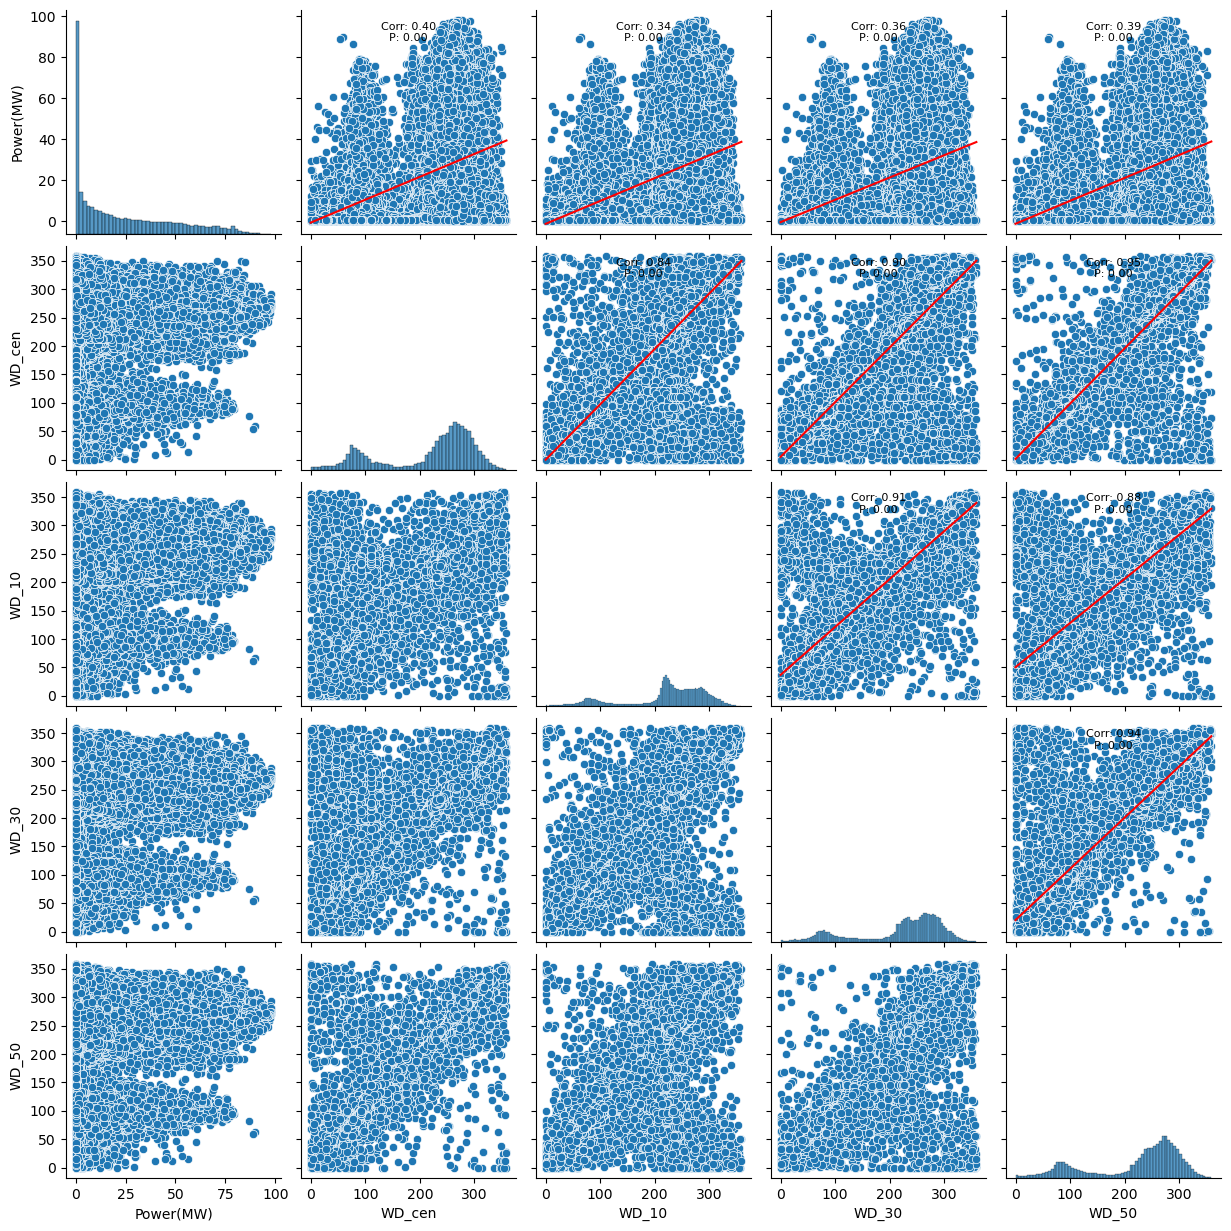

In [92]:
import seaborn as sns
import numpy as np
from scipy import stats

# Define pair plot
pair_plot = sns.pairplot(df_wf1[['Power(MW)', 'WD_cen', 'WD_10', 'WD_30', 'WD_50']])

# Calculate and display correlation and p-value
for i, j in zip(*np.triu_indices_from(pair_plot.axes, 1)):
    ax = pair_plot.axes[i, j]
    x_var, y_var = ax.collections[0].get_offsets().T
    corr_coef, p_val = stats.pearsonr(x_var, y_var)
    ax.annotate("Corr: {:.2f}\nP: {:.2f}".format(corr_coef, p_val),
                xy=(0.5, 0.9), xycoords='axes fraction',
                ha='center', va='center', fontsize=8, color='black')

    # Plot line of best fit
    ax.plot(np.unique(x_var), np.poly1d(np.polyfit(x_var, y_var, 1))(np.unique(x_var)), color='red')

plt.show()